In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import numpy as np
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
from conversion import rotation_matrix_fromq,rotation_matrix_from_params,rotation_matrix_to_q,angles_from_q
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle, clean
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd

from rotation_3d import trilinear_interp,volrotate_trilinear,rotate_coords_3d,rotation_matrix_zyx
from rotation_3d import tricubic_derivatives,tricubic_interp,volrotate_tricubic
from rotation_3d import BSpline_coefficients, Bspline_interp_1d, Bspline_interp, BSpline_derivatives, volrotate_bspline
from Gauss_Newton import print_results,sphere_mask,fourier_filter,get_gradient_P, get_mask_weights
from Gauss_Newton import Gauss_Newton, Gauss_Newton1, Gauss_Newton_Linear, Gauss_Newton_Linear1

In [4]:
july26_dict_PE_AP = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_PE_AP.p','rb'))
july26_dict_PE_RL = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/july26_dict_PE_RL.p','rb'))

In [5]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/July_26_2016_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0', '2_5_to_12_5','15_to_25']
files = clean(os.listdir(path))
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

{'xz': 'xy', 'y': 'z', 'yz': 'xy', 'xy': 'xy', 'x': 'z', 'z': 'z'}
['xz', 'y', 'yz', 'xy', 'x', 'z']


In [6]:
def rep_to_angle(rep, rot_range):
    counter = rep % 6
    rotation_angle = 0.0
    translation_step = rep / 6 

    if rot_range == '0_5_to_2_5':
        if(counter != 0):
            rotation_angle = 0.5 * counter
    elif rot_range == '3_0_to_5_0':
        if(counter != 0):
            rotation_angle = 3.0 + (0.5 * (counter - 1))
    elif rot_range == '2_5_to_12_5':
        if(counter != 0):
            rotation_angle = 2.5 + (2.5 * (counter - 1))        
    elif rot_range == '15_to_25':
        if(counter != 0):
            rotation_angle = 15 + (2.5 * (counter - 1))
    else:
        print 'Invalid range of rotation'
    return rotation_angle, translation_step

In [7]:
def plot_volume_and_mask(dict_, PE = 'AP'):
    # Plot Sample Volume for Abstract
    rot_ax = 'x'
    vol_10 = dict_['10mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)]
    vol_8 = dict_['8mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)]
    vol_6_4 = dict_['6_4mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)]
    vol_10_masked = sphere_mask(fourier_filter(vol_10,13),13)
    vol_8_masked = sphere_mask(fourier_filter(vol_8,16),16)
    vol_6_4_masked = sphere_mask(fourier_filter(vol_6_4,20),20)

    fig, ax = plt.subplots(3,2)
    fig.set_figwidth(6)
    fig.set_figheight(9)
    ax[0][0].imshow(np.fliplr(np.flipud(vol_10[13,:,:].T)), interpolation = 'None', cmap='gray')
    ax[0][0].set_ylabel('10mm',fontsize=18)
    ax[0][0].set_title('Original Volume',fontsize=18)
    ax[1][0].imshow(np.fliplr(np.flipud(vol_8[16,:,:].T)), interpolation = 'None', cmap='gray')
    ax[1][0].set_ylabel('8mm',fontsize=18)
    ax[2][0].imshow(np.fliplr(np.flipud(vol_6_4[20,:,:].T)), interpolation = 'None', cmap='gray')
    ax[2][0].set_ylabel('6.4mm',fontsize=18)
    ax[0][1].imshow(np.fliplr(np.flipud(vol_10_masked[13,:,:].T)), interpolation = 'None', cmap='gray')
    ax[0][1].set_title('Masked Volume',fontsize=18)
    ax[1][1].imshow(np.fliplr(np.flipud(vol_8_masked[16,:,:].T)), interpolation = 'None', cmap='gray')
    ax[2][1].imshow(np.fliplr(np.flipud(vol_6_4_masked[20,:,:].T)), interpolation = 'None', cmap='gray')
    axs = ax.ravel()
    [axs[i].get_xaxis().set_ticks([]) for i in xrange(6)]
    [axs[i].get_yaxis().set_ticks([]) for i in xrange(6)]
    #plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)
    plt.suptitle('PE_%s' % PE, fontsize = 20)
    plt.show()

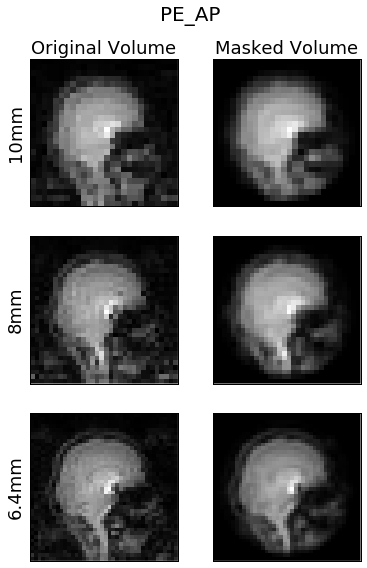

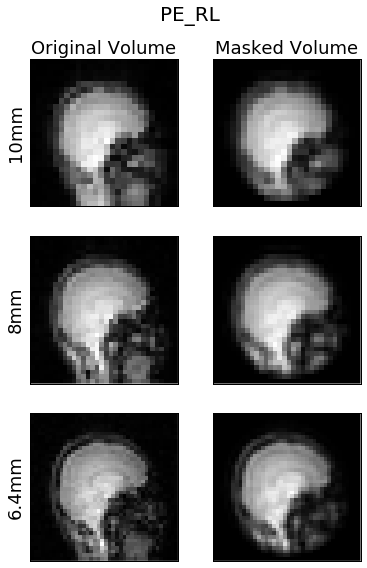

In [8]:
plot_volume_and_mask(july26_dict_PE_AP, PE = 'AP')
plot_volume_and_mask(july26_dict_PE_RL, PE = 'RL')

In [9]:
def plot_diff_slice(vol_6_4_x, vol_6_4_1_x, slice_idx = 19, PE = 'AP'):
    fontsize = 20

    fig, ax = plt.subplots(3,3)
    fig.set_figwidth(10)
    fig.set_figheight(10)
    axes = ax.ravel()

    axes[0].imshow(np.fliplr(vol_6_4_x[:,:,slice_idx].T), interpolation = 'None', cmap='gray')
    axes[0].set_title('Original Slice',fontsize=fontsize)
    axes[1].imshow(np.fliplr(np.flipud(vol_6_4_x[:,slice_idx,:].T)), interpolation = 'None', cmap='gray')
    axes[1].set_title('Original Slice',fontsize=fontsize)
    axes[2].imshow(np.fliplr(np.flipud(vol_6_4_x[slice_idx,:,:].T)), interpolation = 'None', cmap='gray')
    axes[2].set_title('Original Slice',fontsize=fontsize)

    axes[3].imshow(np.fliplr(vol_6_4_1_x[:,:,slice_idx].T), interpolation = 'None', cmap='gray')
    axes[3].set_title('Rotated Slice',fontsize=fontsize)
    axes[4].imshow(np.fliplr(np.flipud(vol_6_4_1_x[:,slice_idx,:].T)), interpolation = 'None', cmap='gray')
    axes[4].set_title('Rotated Slice',fontsize=fontsize)
    axes[5].imshow(np.fliplr(np.flipud(vol_6_4_1_x[slice_idx,:,:].T)), interpolation = 'None', cmap='gray')
    axes[5].set_title('Rotated Slice',fontsize=fontsize)

    axes[6].imshow(np.fliplr(abs(vol_6_4_x-vol_6_4_1_x)[:,:,slice_idx].T), interpolation = 'None', cmap='gray')
    axes[6].set_title('Diff z',fontsize=20)
    axes[7].imshow(np.fliplr(np.flipud(abs(vol_6_4_x-vol_6_4_1_x)[:,slice_idx,:].T)), interpolation = 'None', cmap='gray')
    axes[7].set_title('Diff y',fontsize=fontsize)
    axes[8].imshow(np.fliplr(np.flipud(abs(vol_6_4_x-vol_6_4_1_x)[slice_idx,:,:].T)), interpolation = 'None', cmap='gray')
    axes[8].set_title('Diff x',fontsize=fontsize)
    [axes[i].get_xaxis().set_ticks([]) for i in xrange(4)]
    [axes[i].get_yaxis().set_ticks([]) for i in xrange(4)]
    plt.suptitle('PE_%s' % PE, fontsize = 20)
    #plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.0)
    plt.show()

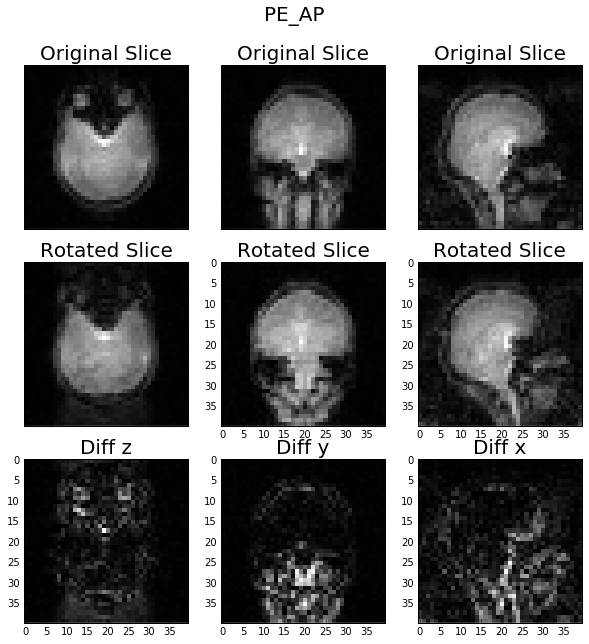

In [10]:
rot_ax = 'x'
vol_6_4_x = july26_dict_PE_AP['6_4mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)]
vol_6_4_masked_x = sphere_mask(fourier_filter(vol_6_4_x,20),20)
vol_6_4_1_x = july26_dict_PE_AP['6_4mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)]
vol_6_4_1_masked_x = sphere_mask(fourier_filter(vol_6_4_1_x,20),20)

plot_diff_slice(vol_6_4_x, vol_6_4_1_x, PE = 'AP')

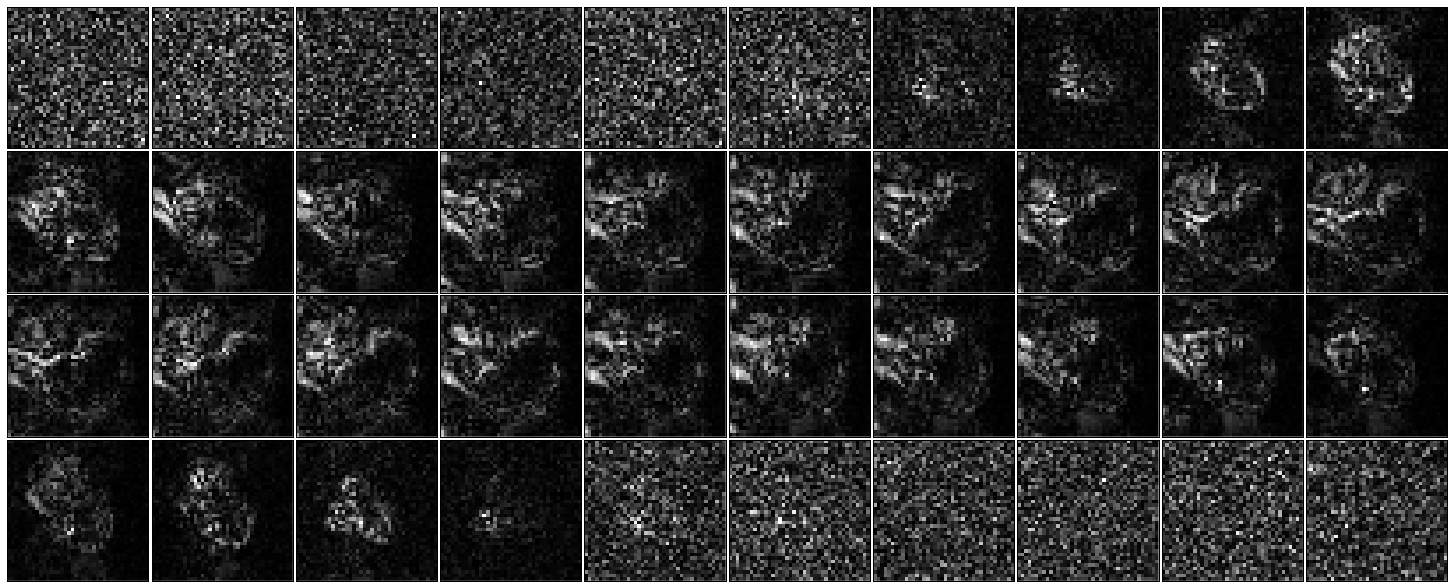

In [11]:
fig, ax = plt.subplots(4,10)
fig.set_figwidth(20)
fig.set_figheight(8)
axes = ax.ravel()
for i in xrange(len(axes)):
    axes[i].imshow(abs(vol_6_4_x-vol_6_4_1_x)[i,:,:], interpolation = 'None', cmap='gray')
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=0.3)
#plt.suptitle('Difference PE AP')
plt.show()

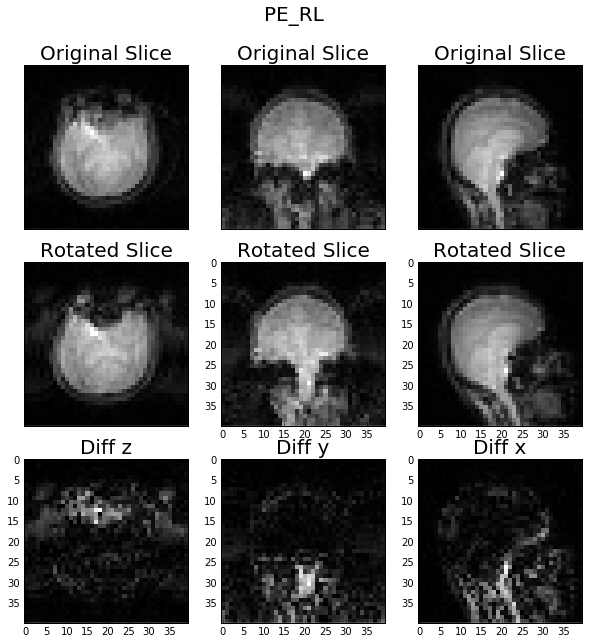

In [12]:
rot_ax = 'x'
vol_6_4_x = july26_dict_PE_RL['6_4mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(0.0, 0)]
vol_6_4_masked_x = sphere_mask(fourier_filter(vol_6_4_x,20),20)
vol_6_4_1_x = july26_dict_PE_RL['6_4mm'][rot_ax][axes_dict[rot_ax]][ranges[2]][(12.5, 0)]
vol_6_4_1_masked_x = sphere_mask(fourier_filter(vol_6_4_1_x,20),20)

plot_diff_slice(vol_6_4_x, vol_6_4_1_x, PE = 'RL')

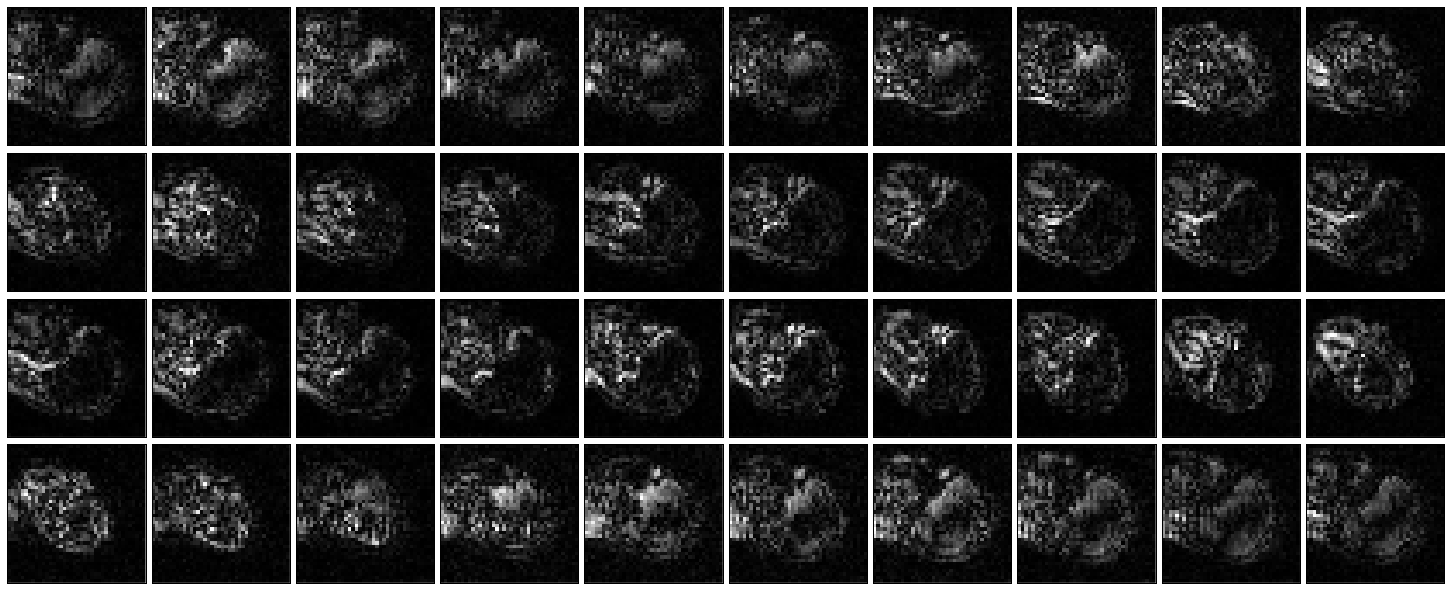

In [13]:
fig, ax = plt.subplots(4,10)
fig.set_figwidth(20)
fig.set_figheight(8)
axes = ax.ravel()
for i in xrange(len(axes)):
    axes[i].imshow(abs(vol_6_4_x-vol_6_4_1_x)[i,:,:], interpolation = 'None', cmap='gray')
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.tight_layout(pad=0, w_pad=0.3, h_pad=1.0)
#plt.suptitle('Difference PE RL')
plt.show()